# COVID-19 Detection from Chest X-rays using InceptionV3

## Introduction
This project aims to develop a deep learning–based image classification model to detect **COVID-19 infections** from **chest X-ray images**. Using **transfer learning** with the **InceptionV3** architecture, the model distinguishes between *COVID-19 positive* and *Non-COVID* cases efficiently and with high accuracy.

This work is part of the **MA 305: Data Science Project** course. The focus is on leveraging pre-trained convolutional architectures, fine-tuning them for medical image classification, and optimizing performance through data preprocessing and augmentation techniques.

The dataset utilized is the **COVID-19 Chest X-ray Dataset**, publicly available on GitHub at:  
🔗 [https://github.com/ieee8023/covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset)


## Importing Required Libraries

Importing all necessary Python libraries for data processing, visualization, and model building.  
Includes TensorFlow and Keras for deep learning, scikit-learn for evaluation metrics, and OpenCV for image handling.  
Mixed precision is enabled for faster training performance.


In [ ]:
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

print("Modules Loaded")

Modules Loaded


## Test-Time Augmentation (TTA)

Applies flips and brightness/contrast tweaks at inference, averaging predictions to improve model stability and accuracy.



In [ ]:
# Test-Time Augmentation (TTA)
class TTAPredictor:
    def __init__(self, model, n_augments=7):
        self.model = model
        self.n_augments = n_augments

    def predict(self, image_batch):
        predictions = []

        # Original prediction
        predictions.append(self.model.predict(image_batch, verbose=0))

        # Horizontal flip
        flipped = tf.image.flip_left_right(image_batch)
        predictions.append(self.model.predict(flipped, verbose=0))

        # Brightness variations
        for brightness_delta in [0.1, -0.1]:
            aug_batch = tf.image.adjust_brightness(image_batch, brightness_delta)
            predictions.append(self.model.predict(aug_batch, verbose=0))

        # Contrast variations
        for contrast_factor in [1.1, 0.9]:
            aug_batch = tf.image.adjust_contrast(image_batch, contrast_factor)
            predictions.append(self.model.predict(aug_batch, verbose=0))

        # Random combination
        aug_batch = tf.image.flip_left_right(image_batch)
        aug_batch = tf.image.adjust_brightness(aug_batch, 0.05)
        predictions.append(self.model.predict(aug_batch, verbose=0))

        # Average predictions
        return np.mean(predictions[:self.n_augments], axis=0)

## Data Loading Functions

Defines helper functions to read image paths and labels from the dataset metadata.  
Filters X-ray images, assigns labels (*COVID-19* or *Non-Covid*), and builds a clean DataFrame for further preprocessing.


In [ ]:
# Data Loading Functions
def define_paths(data_dir, metadata_path):
    filepaths = []
    labels = []

    df = pd.read_csv(metadata_path)
    df = df[df["finding"].notna()]
    df = df[df["modality"].notna()]
    df = df[df["view"].notna()]
    df = df[(df["modality"] == "X-ray") & (~df["view"].isin(["L", "Axial"]))]

    for _, row in df.iterrows():
        finding = row["finding"].strip()
        fname = row["filename"]
        img_path = os.path.join(data_dir, fname)
        if finding == "Pneumonia/Viral/COVID-19":
            label = "COVID-19"
        else:
            label = "Non-Covid"

        if os.path.exists(img_path):
            filepaths.append(img_path)
            labels.append(label)

    return filepaths, labels


def define_df(files, labels):
    return pd.DataFrame({"filepaths": files, "labels": labels})

## Data Augmentation

Defines helper functions to create image data generators for training, validation, and testing.\
The training generator applies various standard augmentations like rotation, shifting, and zooming.\
Both generators include the necessary preprocessing function for the InceptionV3 model.

In [ ]:
# Data Augmentation
def get_advanced_train_generator():
    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        zoom_range=[0.75, 1.25],
        brightness_range=[0.6, 1.4],
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='reflect',
        channel_shift_range=25,
        preprocessing_function=lambda x: tf.keras.applications.inception_v3.preprocess_input(x)
    )


def get_valid_test_generator():
    return ImageDataGenerator(
        preprocessing_function=lambda x: tf.keras.applications.inception_v3.preprocess_input(x)
    )

## InceptionV3 Model with Dual Pooling

Builds an enhanced InceptionV3-based CNN for COVID-19 classification.  
Combines global average and max pooling for richer feature extraction and adds a deep fully connected head with batch normalization, dropout, and L1–L2 regularization for better generalization.


In [ ]:
# InceptionV3 with Dual Pooling
def create_enhanced_inceptionv3_model(img_shape=(299, 299, 3), class_count=2):

    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=img_shape,
        pooling=None
    )
    base_model.trainable = False

    # Dual pooling: combines average and max pooling
    model = Sequential([
        base_model,
    ])

    # Custom head with dual pooling
    avg_pool = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    max_pool = GlobalMaxPooling2D(name='max_pool')(base_model.output)
    concat = Concatenate(name='concat_pool')([avg_pool, max_pool])

    # Deep classification head
    x = BatchNormalization(name='bn1')(concat)
    x = Dense(1536, kernel_regularizer=l1_l2(l1=0.0001, l2=0.001), name='fc1')(x)
    x = Activation('relu', name='relu1')(x)
    x = Dropout(0.6, name='dropout1')(x)

    x = BatchNormalization(name='bn2')(x)
    x = Dense(768, kernel_regularizer=l1_l2(l1=0.0001, l2=0.001), name='fc2')(x)
    x = Activation('relu', name='relu2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    x = BatchNormalization(name='bn3')(x)
    x = Dense(384, kernel_regularizer=l1_l2(l1=0.0001, l2=0.001), name='fc3')(x)
    x = Activation('relu', name='relu3')(x)
    x = Dropout(0.4, name='dropout3')(x)

    x = BatchNormalization(name='bn4')(x)
    x = Dense(192, kernel_regularizer=l1_l2(l1=0.0001, l2=0.001), name='fc4')(x)
    x = Activation('relu', name='relu4')(x)
    x = Dropout(0.3, name='dropout4')(x)

    output = Dense(class_count, activation='softmax', dtype='float32', name='output')(x)

    # Build functional model
    from tensorflow.keras.models import Model
    model = Model(inputs=base_model.input, outputs=output)

    return model, base_model

## Plotting Functions

Provides visualization utilities for model performance analysis.  
`plot_training()` displays training and validation accuracy/loss curves, while `plot_confusion_matrix()` visualizes classification performance across classes.


In [ ]:
# Plotting Functions
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(tr_acc)+1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'g', label='Validation Loss', linewidth=2)
    plt.title("Training vs Validation Loss", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy', linewidth=2)
    plt.title("Training vs Validation Accuracy", fontsize=14, fontweight='bold')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize=16, fontweight='bold', pad=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", fontsize=16,
                 color="white" if cm[i, j] > thresh else "black",
                 fontweight='bold')

    plt.ylabel("True Label", fontsize=13, fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Loading and Preparing the Dataset

Clones the COVID-19 Chest X-ray dataset from GitHub and constructs a balanced DataFrame.  
Performs aggressive oversampling to equalize class distribution and splits the data into training, validation, and test sets for model evaluation.


In [ ]:
# Load and Prepare DataFrame

# Clone dataset
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git
data_dir = "covid-chestxray-dataset/images"
metadata_path = "covid-chestxray-dataset/metadata.csv"

# Load and prepare data
files, labels = define_paths(data_dir, metadata_path)
df = define_df(files, labels)

print("="*60)
print("Before balancing:")
print("="*60)
print(df["labels"].value_counts())

# Aggressive oversampling for perfect balance
covid_df = df[df["labels"] == "COVID-19"].copy()
noncovid_df = df[df["labels"] == "Non-Covid"].copy()

target_size = max(len(covid_df), len(noncovid_df))

# Oversample minority class
if len(covid_df) < target_size:
    covid_df = covid_df.sample(n=target_size, replace=True, random_state=42)
if len(noncovid_df) < target_size:
    noncovid_df = noncovid_df.sample(n=target_size, replace=True, random_state=42)

df_balanced = pd.concat([covid_df, noncovid_df], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n" + "="*60)
print("After balancing:")
print("="*60)
print(df_balanced["labels"].value_counts())

# Split data
train_df, dummy_df = train_test_split(
    df_balanced, train_size=0.8, random_state=42, stratify=df_balanced["labels"]
)
valid_df, test_df = train_test_split(
    dummy_df, train_size=0.5, random_state=42, stratify=dummy_df["labels"]
)

print(f"\n{'='*60}")
print(f"Dataset Split:")
print(f"{'='*60}")
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641 (from 1)
Receiving objects: 100% (3641/3641), 632.96 MiB | 34.90 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.
Before balancing:
labels
COVID-19     478
Non-Covid    304
Name: count, dtype: int64

After balancing:
labels
COVID-19     478
Non-Covid    478
Name: count, dtype: int64

Dataset Split:
Train: 764, Valid: 96, Test: 96


## Data Generators, Model Creation, and Compilation

Initializes image data generators for training, validation, and testing with preprocessing and augmentation.  
Computes class weights to handle imbalance and builds the enhanced InceptionV3 model.  
Compiles the model with the Nadam optimizer.


In [ ]:
# Create generators
train_datagen = get_advanced_train_generator()
valid_test_datagen = get_valid_test_generator()

BATCH_SIZE = 12
IMG_SIZE = (299, 299)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="filepaths", y_col="labels",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=True
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df, x_col="filepaths", y_col="labels",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df, x_col="filepaths", y_col="labels",
    target_size=IMG_SIZE, color_mode="rgb",
    class_mode="categorical", batch_size=BATCH_SIZE, shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")

# Create model
print("\n" + "="*60)
print("Creating InceptionV3 Model")
print("="*60)

model, base_model = create_enhanced_inceptionv3_model(
    img_shape=(*IMG_SIZE, 3),
    class_count=len(train_gen.class_indices)
)

# Compile with Nadam optimizer (better than Adam for this task)
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Found 764 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Creating InceptionV3 Model


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_940 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_940[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_940      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_941 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_940[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_941[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_941      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_942 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_941[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_942[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_942      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 73, 73,    │          0 │ activation_942[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_943 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_40… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_943[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_943      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_944 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_943[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_944[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_944      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 29,672,930 (113.19 MB)

 Trainable params: 7,856,578 (29.97 MB)

 Non-trainable params: 21,816,352 (83.22 MB)

## Image Before and After Augmentation

Displays a single training image in its original form and after applying the data augmentation pipeline to visualize the transformations.


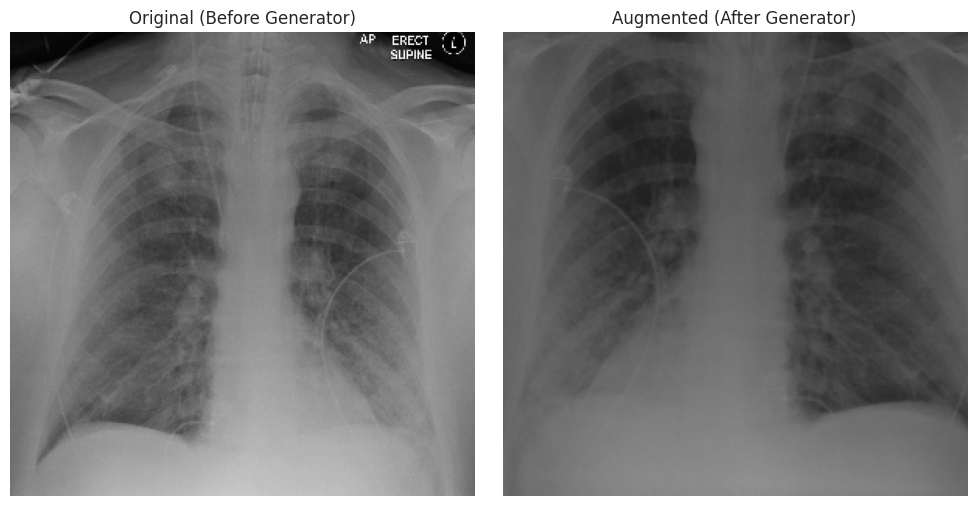

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

sample_image_path = train_df['filepaths'].iloc[10]

original_img = cv2.imread(sample_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (299, 299))

img_batch = np.expand_dims(original_img, axis=0)
train_datagen = get_advanced_train_generator()
temp_gen = train_datagen.flow(img_batch, batch_size=1, shuffle=False)
augmented_img = next(temp_gen)[0]
def reverse_inceptionv3_preprocessing(processed_img):
    return np.clip(((processed_img + 1) / 2) * 255, 0, 255).astype(np.uint8)

augmented_img_vis = reverse_inceptionv3_preprocessing(augmented_img)
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title("Original (Before Generator)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(augmented_img_vis)
plt.title("Augmented (After Generator)")
plt.axis("off")

plt.tight_layout()
plt.show()


## Callbacks

Defines custom training callbacks for improved monitoring and learning control.  
`F1ScoreCallback` tracks the validation F1-score each epoch, saving the best result.  

Sets up essential callbacks for learning rate scheduling, early stopping, and F1-score tracking.



In [ ]:
class F1ScoreCallback(keras.callbacks.Callback):
    def __init__(self, validation_generator):
        super().__init__()
        self.validation_generator = validation_generator
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.validation_generator, verbose=0)
        val_pred_classes = np.argmax(val_pred, axis=1)
        val_true = self.validation_generator.classes

        f1 = f1_score(val_true, val_pred_classes, average='weighted')

        print(f"\nValidation F1-Score: {f1:.4f}")
        logs['val_f1'] = f1

        if f1 > self.best_f1:
            self.best_f1 = f1
            print(f"✓ New best F1-Score: {f1:.4f}")


# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_f1',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=6,
        min_lr=1e-9,
        verbose=1,
        cooldown=2
    ),
    ModelCheckpoint(
        'best_inceptionv3_enhanced.h5',
        monitor='val_f1',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    F1ScoreCallback(valid_gen)
]

## Phase 1: Initial Training with Frozen Base

Trains only the custom classification head while keeping the InceptionV3 base frozen.  
Runs for 30 epochs to initialize weights and stabilize the new layers before fine-tuning.



PHASE 1: Initial Training (30 epochs)
Frozen InceptionV3 base
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.4724 - auc: 0.4473 - loss: 19.6675 - precision: 0.4724 - recall: 0.4724


Validation F1-Score: 0.3725
✓ New best F1-Score: 0.3725
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.4730 - auc: 0.4483 - loss: 19.6663 - precision: 0.4730 - recall: 0.4730 - val_accuracy: 0.5104 - val_auc: 0.5537 - val_loss: 19.6640 - val_precision: 0.5104 - val_recall: 0.5104 - learning_rate: 0.0010 - val_f1: 0.3725
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5475 - auc: 0.5595 - loss: 19.5546 - precision: 0.5475 - recall: 0.5475


Validation F1-Score: 0.5338
✓ New best F1-Score: 0.5338
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 669ms/step - accuracy: 0.5476 - auc: 0.5598 - loss: 19.5544 - precision: 0.5476 - recall: 0.5476 - val_accuracy: 0.5521 - val_auc: 0.5986 - val_loss: 19.3873 - val_precision: 0.5521 - val_recall: 0.5521 - learning_rate: 0.0010 - val_f1: 0.5338
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.5893 - auc: 0.6234 - loss: 19.3880 - precision: 0.5893 - recall: 0.5893


Validation F1-Score: 0.5865
✓ New best F1-Score: 0.5865
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 657ms/step - accuracy: 0.5890 - auc: 0.6231 - loss: 19.3871 - precision: 0.5890 - recall: 0.5890 - val_accuracy: 0.6146 - val_auc: 0.6641 - val_loss: 18.9854 - val_precision: 0.6146 - val_recall: 0.6146 - learning_rate: 0.0010 - val_f1: 0.5865
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.5560 - auc: 0.5614 - loss: 19.0143 - precision: 0.5560 - recall: 0.5560


Validation F1-Score: 0.6742
✓ New best F1-Score: 0.6742
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 663ms/step - accuracy: 0.5561 - auc: 0.5617 - loss: 19.0123 - precision: 0.5561 - recall: 0.5561 - val_accuracy: 0.6771 - val_auc: 0.6828 - val_loss: 18.5630 - val_precision: 0.6771 - val_recall: 0.6771 - learning_rate: 0.0010 - val_f1: 0.6742
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5809 - auc: 0.6294 - loss: 18.4460 - precision: 0.5809 - recall: 0.5809


Validation F1-Score: 0.5622
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 643ms/step - accuracy: 0.5806 - auc: 0.6289 - loss: 18.4447 - precision: 0.5806 - recall: 0.5806 - val_accuracy: 0.5729 - val_auc: 0.6398 - val_loss: 18.0175 - val_precision: 0.5729 - val_recall: 0.5729 - learning_rate: 0.0010 - val_f1: 0.5622
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.5764 - auc: 0.5994 - loss: 17.9799 - precision: 0.5764 - recall: 0.5764


Validation F1-Score: 0.6040
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 785ms/step - accuracy: 0.5769 - auc: 0.6000 - loss: 17.9772 - precision: 0.5769 - recall: 0.5769 - val_accuracy: 0.6042 - val_auc: 0.6451 - val_loss: 17.4476 - val_precision: 0.6042 - val_recall: 0.6042 - learning_rate: 0.0010 - val_f1: 0.6040
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.5774 - auc: 0.5940 - loss: 17.4100 - precision: 0.5774 - recall: 0.5774


Validation F1-Score: 0.6142
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 878ms/step - accuracy: 0.5776 - auc: 0.5944 - loss: 17.4072 - precision: 0.5776 - recall: 0.5776 - val_accuracy: 0.6146 - val_auc: 0.6701 - val_loss: 16.8236 - val_precision: 0.6146 - val_recall: 0.6146 - learning_rate: 0.0010 - val_f1: 0.6142
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5421 - auc: 0.5762 - loss: 16.7971 - precision: 0.5421 - recall: 0.5421


Validation F1-Score: 0.5862
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 771ms/step - accuracy: 0.5424 - auc: 0.5764 - loss: 16.7945 - precision: 0.5424 - recall: 0.5424 - val_accuracy: 0.6042 - val_auc: 0.6875 - val_loss: 16.2126 - val_precision: 0.6042 - val_recall: 0.6042 - learning_rate: 0.0010 - val_f1: 0.5862
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.5932 - auc: 0.6222 - loss: 16.1389 - precision: 0.5932 - recall: 0.5932


Validation F1-Score: 0.6135
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 827ms/step - accuracy: 0.5930 - auc: 0.6218 - loss: 16.1367 - precision: 0.5930 - recall: 0.5930 - val_accuracy: 0.6146 - val_auc: 0.6783 - val_loss: 15.5279 - val_precision: 0.6146 - val_recall: 0.6146 - learning_rate: 0.0010 - val_f1: 0.6135
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.6566 - auc: 0.7121 - loss: 15.3484 - precision: 0.6566 - recall: 0.6566


Validation F1-Score: 0.5672
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 807ms/step - accuracy: 0.6560 - auc: 0.7114 - loss: 15.3463 - precision: 0.6560 - recall: 0.6560 - val_accuracy: 0.5729 - val_auc: 0.6428 - val_loss: 14.8350 - val_precision: 0.5729 - val_recall: 0.5729 - learning_rate: 0.0010 - val_f1: 0.5672
Epoch 11/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.6181 - auc: 0.6774 - loss: 14.6626 - precision: 0.6181 - recall: 0.6181


Validation F1-Score: 0.6458
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 797ms/step - accuracy: 0.6183 - auc: 0.6776 - loss: 14.6598 - precision: 0.6183 - recall: 0.6183 - val_accuracy: 0.6458 - val_auc: 0.7373 - val_loss: 14.0898 - val_precision: 0.6458 - val_recall: 0.6458 - learning_rate: 0.0010 - val_f1: 0.6458
Epoch 12/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6345 - auc: 0.7096 - loss: 13.9678 - precision: 0.6345 - recall: 0.6345


Validation F1-Score: 0.6562
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 894ms/step - accuracy: 0.6345 - auc: 0.7094 - loss: 13.9660 - precision: 0.6345 - recall: 0.6345 - val_accuracy: 0.6562 - val_auc: 0.7126 - val_loss: 13.5726 - val_precision: 0.6562 - val_recall: 0.6562 - learning_rate: 0.0010 - val_f1: 0.6562
Epoch 13/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6638 - auc: 0.7115 - loss: 13.4343 - precision: 0.6638 - recall: 0.6638


Validation F1-Score: 0.6419
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 748ms/step - accuracy: 0.6635 - auc: 0.7114 - loss: 13.4321 - precision: 0.6635 - recall: 0.6635 - val_accuracy: 0.6458 - val_auc: 0.7278 - val_loss: 12.9876 - val_precision: 0.6458 - val_recall: 0.6458 - learning_rate: 0.0010 - val_f1: 0.6419
Epoch 14/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.6499 - auc: 0.6865 - loss: 12.9202 - precision: 0.6499 - recall: 0.6499


Validation F1-Score: 0.6825
✓ New best F1-Score: 0.6825
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 821ms/step - accuracy: 0.6499 - auc: 0.6865 - loss: 12.9183 - precision: 0.6499 - recall: 0.6499 - val_accuracy: 0.6875 - val_auc: 0.7316 - val_loss: 12.4937 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 0.0010 - val_f1: 0.6825
Epoch 15/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.6586 - auc: 0.6816 - loss: 12.3936 - precision: 0.6586 - recall: 0.6586


Validation F1-Score: 0.7082
✓ New best F1-Score: 0.7082
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 905ms/step - accuracy: 0.6583 - auc: 0.6815 - loss: 12.3914 - precision: 0.6583 - recall: 0.6583 - val_accuracy: 0.7083 - val_auc: 0.7443 - val_loss: 11.8875 - val_precision: 0.7083 - val_recall: 0.7083 - learning_rate: 0.0010 - val_f1: 0.7082
Epoch 16/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.6545 - auc: 0.6918 - loss: 11.7908 - precision: 0.6545 - recall: 0.6545


Validation F1-Score: 0.6728
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 803ms/step - accuracy: 0.6546 - auc: 0.6920 - loss: 11.7885 - precision: 0.6546 - recall: 0.6546 - val_accuracy: 0.6771 - val_auc: 0.7604 - val_loss: 11.3104 - val_precision: 0.6771 - val_recall: 0.6771 - learning_rate: 0.0010 - val_f1: 0.6728
Epoch 17/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6783 - auc: 0.7301 - loss: 11.1881 - precision: 0.6783 - recall: 0.6783


Validation F1-Score: 0.6357
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 867ms/step - accuracy: 0.6781 - auc: 0.7301 - loss: 11.1861 - precision: 0.6781 - recall: 0.6781 - val_accuracy: 0.6458 - val_auc: 0.7336 - val_loss: 10.7884 - val_precision: 0.6458 - val_recall: 0.6458 - learning_rate: 0.0010 - val_f1: 0.6357
Epoch 18/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6548 - auc: 0.7077 - loss: 10.6868 - precision: 0.6548 - recall: 0.6548


Validation F1-Score: 0.7496
✓ New best F1-Score: 0.7496
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 757ms/step - accuracy: 0.6548 - auc: 0.7077 - loss: 10.6850 - precision: 0.6548 - recall: 0.6548 - val_accuracy: 0.7500 - val_auc: 0.7567 - val_loss: 10.3524 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 0.0010 - val_f1: 0.7496
Epoch 19/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.6687 - auc: 0.7362 - loss: 10.2951 - precision: 0.6687 - recall: 0.6687


Validation F1-Score: 0.6770
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 802ms/step - accuracy: 0.6684 - auc: 0.7356 - loss: 10.2943 - precision: 0.6684 - recall: 0.6684 - val_accuracy: 0.6771 - val_auc: 0.7126 - val_loss: 10.0139 - val_precision: 0.6771 - val_recall: 0.6771 - learning_rate: 0.0010 - val_f1: 0.6770
Epoch 20/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.6907 - auc: 0.7357 - loss: 9.9341 - precision: 0.6907 - recall: 0.6907


Validation F1-Score: 0.6875
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 876ms/step - accuracy: 0.6906 - auc: 0.7355 - loss: 9.9332 - precision: 0.6906 - recall: 0.6906 - val_accuracy: 0.6875 - val_auc: 0.7760 - val_loss: 9.7147 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 0.0010 - val_f1: 0.6875
Epoch 21/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6944 - auc: 0.7714 - loss: 9.6202 - precision: 0.6944 - recall: 0.6944


Validation F1-Score: 0.6614
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 727ms/step - accuracy: 0.6940 - auc: 0.7709 - loss: 9.6195 - precision: 0.6940 - recall: 0.6940 - val_accuracy: 0.6667 - val_auc: 0.7454 - val_loss: 9.4302 - val_precision: 0.6667 - val_recall: 0.6667 - learning_rate: 0.0010 - val_f1: 0.6614
Epoch 22/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.6788 - auc: 0.7424 - loss: 9.3490 - precision: 0.6788 - recall: 0.6788


Validation F1-Score: 0.6190
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 684ms/step - accuracy: 0.6788 - auc: 0.7424 - loss: 9.3474 - precision: 0.6788 - recall: 0.6788 - val_accuracy: 0.6250 - val_auc: 0.7324 - val_loss: 9.0277 - val_precision: 0.6250 - val_recall: 0.6250 - learning_rate: 0.0010 - val_f1: 0.6190
Epoch 23/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6803 - auc: 0.7346 - loss: 8.9666 - precision: 0.6803 - recall: 0.6803


Validation F1-Score: 0.6971
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 664ms/step - accuracy: 0.6806 - auc: 0.7349 - loss: 8.9653 - precision: 0.6806 - recall: 0.6806 - val_accuracy: 0.6979 - val_auc: 0.7958 - val_loss: 8.7024 - val_precision: 0.6979 - val_recall: 0.6979 - learning_rate: 0.0010 - val_f1: 0.6971
Epoch 24/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6682 - auc: 0.7318 - loss: 8.7144 - precision: 0.6682 - recall: 0.6682


Validation F1-Score: 0.6457
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 652ms/step - accuracy: 0.6683 - auc: 0.7318 - loss: 8.7131 - precision: 0.6683 - recall: 0.6683 - val_accuracy: 0.6458 - val_auc: 0.7559 - val_loss: 8.4368 - val_precision: 0.6458 - val_recall: 0.6458 - learning_rate: 0.0010 - val_f1: 0.6457
Epoch 25/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7038 - auc: 0.7603 - loss: 8.3602 - precision: 0.7038 - recall: 0.7038


Validation F1-Score: 0.7180
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 664ms/step - accuracy: 0.7035 - auc: 0.7602 - loss: 8.3594 - precision: 0.7035 - recall: 0.7035 - val_accuracy: 0.7188 - val_auc: 0.7726 - val_loss: 8.2318 - val_precision: 0.7188 - val_recall: 0.7188 - learning_rate: 0.0010 - val_f1: 0.7180
Epoch 26/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6944 - auc: 0.7864 - loss: 8.1446 - precision: 0.6944 - recall: 0.6944


Validation F1-Score: 0.6553
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.6942 - auc: 0.7861 - loss: 8.1440 - precision: 0.6942 - recall: 0.6942 - val_accuracy: 0.6562 - val_auc: 0.7300 - val_loss: 8.0895 - val_precision: 0.6562 - val_recall: 0.6562 - learning_rate: 0.0010 - val_f1: 0.6553
Epoch 27/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6879 - auc: 0.7342 - loss: 8.0505 - precision: 0.6879 - recall: 0.6879


Validation F1-Score: 0.6754
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 654ms/step - accuracy: 0.6875 - auc: 0.7340 - loss: 8.0495 - precision: 0.6875 - recall: 0.6875 - val_accuracy: 0.6771 - val_auc: 0.7601 - val_loss: 7.8346 - val_precision: 0.6771 - val_recall: 0.6771 - learning_rate: 0.0010 - val_f1: 0.6754
Epoch 28/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6924 - auc: 0.7479 - loss: 7.7754 - precision: 0.6924 - recall: 0.6924


Validation F1-Score: 0.7262
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 657ms/step - accuracy: 0.6922 - auc: 0.7478 - loss: 7.7742 - precision: 0.6922 - recall: 0.6922 - val_accuracy: 0.7292 - val_auc: 0.8051 - val_loss: 7.4912 - val_precision: 0.7292 - val_recall: 0.7292 - learning_rate: 0.0010 - val_f1: 0.7262
Epoch 29/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.6594 - auc: 0.7166 - loss: 7.4897 - precision: 0.6594 - recall: 0.6594


Validation F1-Score: 0.7172
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 672ms/step - accuracy: 0.6594 - auc: 0.7166 - loss: 7.4890 - precision: 0.6594 - recall: 0.6594 - val_accuracy: 0.7188 - val_auc: 0.7918 - val_loss: 7.3183 - val_precision: 0.7188 - val_recall: 0.7188 - learning_rate: 0.0010 - val_f1: 0.7172
Epoch 30/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7034 - auc: 0.7701 - loss: 7.2926 - precision: 0.7034 - recall: 0.7034


Validation F1-Score: 0.6971
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 654ms/step - accuracy: 0.7032 - auc: 0.7700 - loss: 7.2919 - precision: 0.7032 - recall: 0.7032 - val_accuracy: 0.6979 - val_auc: 0.8242 - val_loss: 7.1339 - val_precision: 0.6979 - val_recall: 0.6979 - learning_rate: 0.0010 - val_f1: 0.6971


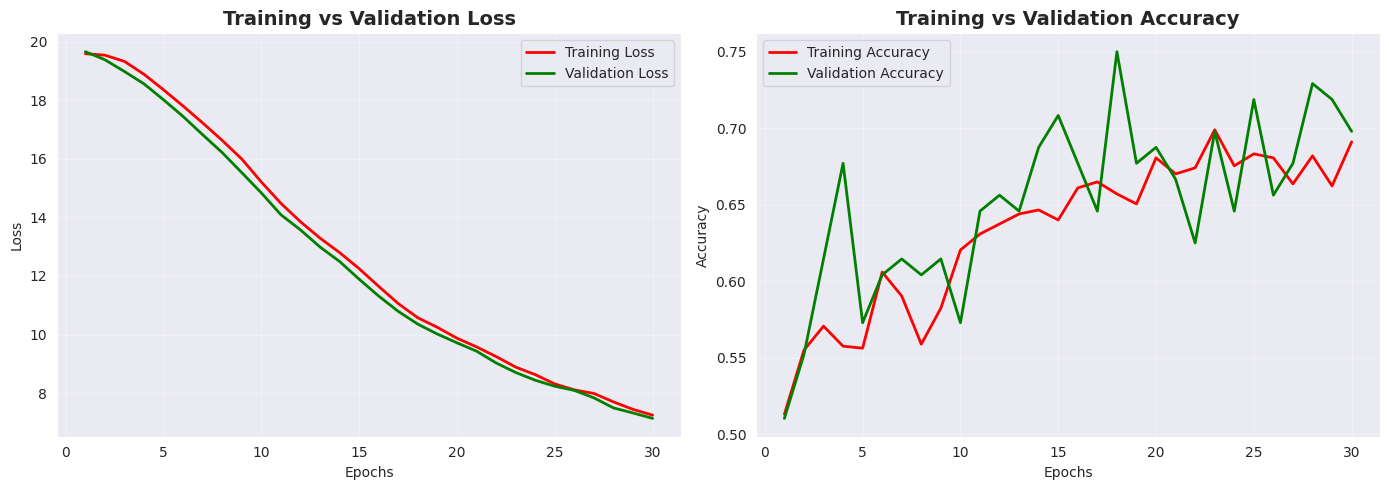

In [ ]:
# Phase 1: Train with frozen base
print("\n" + "="*60)
print("PHASE 1: Initial Training (30 epochs)")
print("Frozen InceptionV3 base")
print("="*60)

history1 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

plot_training(history1)

## Phase 2: Fine-Tuning the Top Layers

Unfreezes the top 40% of the InceptionV3 base layers to fine-tune learned representations.  
Recompiles the model with a lower learning rate and trains for 25 epochs to improve feature adaptation and overall accuracy.



PHASE 2: Fine-tuning Top 40% Layers (25 epochs)
Unfrozen 125 layers
Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6352 - auc: 0.6875 - loss: 7.0885 - precision: 0.6352 - recall: 0.6352   


Validation F1-Score: 0.7382
64/64 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6354 - auc: 0.6879 - loss: 7.0866 - precision: 0.6354 - recall: 0.6354 - val_accuracy: 0.7396 - val_auc: 0.8625 - val_loss: 6.6238 - val_precision: 0.7396 - val_recall: 0.7396 - learning_rate: 1.0000e-04 - val_f1: 0.7382
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.7290 - auc: 0.7835 - loss: 6.6279 - precision: 0.7290 - recall: 0.7290


Validation F1-Score: 0.6904
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 675ms/step - accuracy: 0.7292 - auc: 0.7838 - loss: 6.6262 - precision: 0.7292 - recall: 0.7292 - val_accuracy: 0.6979 - val_auc: 0.8187 - val_loss: 6.2897 - val_precision: 0.6979 - val_recall: 0.6979 - learning_rate: 1.0000e-04 - val_f1: 0.6904
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7790 - auc: 0.8478 - loss: 6.1925 - precision: 0.7790 - recall: 0.7790


Validation F1-Score: 0.7262
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 691ms/step - accuracy: 0.7788 - auc: 0.8478 - loss: 6.1913 - precision: 0.7788 - recall: 0.7788 - val_accuracy: 0.7292 - val_auc: 0.8517 - val_loss: 5.9067 - val_precision: 0.7292 - val_recall: 0.7292 - learning_rate: 1.0000e-04 - val_f1: 0.7262
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7829 - auc: 0.8770 - loss: 5.8270 - precision: 0.7829 - recall: 0.7829


Validation F1-Score: 0.7347
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 666ms/step - accuracy: 0.7830 - auc: 0.8769 - loss: 5.8260 - precision: 0.7830 - recall: 0.7830 - val_accuracy: 0.7396 - val_auc: 0.8352 - val_loss: 5.6561 - val_precision: 0.7396 - val_recall: 0.7396 - learning_rate: 1.0000e-04 - val_f1: 0.7347
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8125 - auc: 0.8893 - loss: 5.5112 - precision: 0.8125 - recall: 0.8125


Validation F1-Score: 0.7598
✓ New best F1-Score: 0.7598
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 675ms/step - accuracy: 0.8124 - auc: 0.8891 - loss: 5.5105 - precision: 0.8124 - recall: 0.8124 - val_accuracy: 0.7604 - val_auc: 0.8424 - val_loss: 5.3751 - val_precision: 0.7604 - val_recall: 0.7604 - learning_rate: 1.0000e-04 - val_f1: 0.7598
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8129 - auc: 0.8801 - loss: 5.2624 - precision: 0.8129 - recall: 0.8129


Validation F1-Score: 0.8003
✓ New best F1-Score: 0.8003
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 770ms/step - accuracy: 0.8129 - auc: 0.8801 - loss: 5.2614 - precision: 0.8129 - recall: 0.8129 - val_accuracy: 0.8021 - val_auc: 0.8685 - val_loss: 5.0984 - val_precision: 0.8021 - val_recall: 0.8021 - learning_rate: 1.0000e-04 - val_f1: 0.8003
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8527 - auc: 0.9181 - loss: 4.9505 - precision: 0.8527 - recall: 0.8527


Validation F1-Score: 0.7473
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 770ms/step - accuracy: 0.8524 - auc: 0.9179 - loss: 4.9500 - precision: 0.8524 - recall: 0.8524 - val_accuracy: 0.7500 - val_auc: 0.8672 - val_loss: 4.8548 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-04 - val_f1: 0.7473
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8654 - auc: 0.9296 - loss: 4.7052 - precision: 0.8654 - recall: 0.8654


Validation F1-Score: 0.8125
✓ New best F1-Score: 0.8125
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 730ms/step - accuracy: 0.8650 - auc: 0.9293 - loss: 4.7049 - precision: 0.8650 - recall: 0.8650 - val_accuracy: 0.8125 - val_auc: 0.8808 - val_loss: 4.6644 - val_precision: 0.8125 - val_recall: 0.8125 - learning_rate: 1.0000e-04 - val_f1: 0.8125
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8441 - auc: 0.9241 - loss: 4.5220 - precision: 0.8441 - recall: 0.8441


Validation F1-Score: 0.7290
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 763ms/step - accuracy: 0.8441 - auc: 0.9239 - loss: 4.5216 - precision: 0.8441 - recall: 0.8441 - val_accuracy: 0.7292 - val_auc: 0.8741 - val_loss: 4.4640 - val_precision: 0.7292 - val_recall: 0.7292 - learning_rate: 1.0000e-04 - val_f1: 0.7290
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8723 - auc: 0.9274 - loss: 4.3512 - precision: 0.8723 - recall: 0.8723


Validation F1-Score: 0.7598
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 737ms/step - accuracy: 0.8720 - auc: 0.9272 - loss: 4.3508 - precision: 0.8720 - recall: 0.8720 - val_accuracy: 0.7604 - val_auc: 0.8781 - val_loss: 4.3184 - val_precision: 0.7604 - val_recall: 0.7604 - learning_rate: 1.0000e-04 - val_f1: 0.7598
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8445 - auc: 0.9213 - loss: 4.1993 - precision: 0.8445 - recall: 0.8445


Validation F1-Score: 0.7604
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 735ms/step - accuracy: 0.8450 - auc: 0.9217 - loss: 4.1979 - precision: 0.8450 - recall: 0.8450 - val_accuracy: 0.7604 - val_auc: 0.8780 - val_loss: 4.1395 - val_precision: 0.7604 - val_recall: 0.7604 - learning_rate: 1.0000e-04 - val_f1: 0.7604
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8778 - auc: 0.9501 - loss: 3.9584 - precision: 0.8778 - recall: 0.8778


Validation F1-Score: 0.8646
✓ New best F1-Score: 0.8646
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 739ms/step - accuracy: 0.8779 - auc: 0.9501 - loss: 3.9579 - precision: 0.8779 - recall: 0.8779 - val_accuracy: 0.8646 - val_auc: 0.9081 - val_loss: 3.9824 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 1.0000e-04 - val_f1: 0.8646
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.8935 - auc: 0.9536 - loss: 3.7978 - precision: 0.8935 - recall: 0.8935


Validation F1-Score: 0.7917
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 695ms/step - accuracy: 0.8934 - auc: 0.9535 - loss: 3.7976 - precision: 0.8934 - recall: 0.8934 - val_accuracy: 0.7917 - val_auc: 0.8778 - val_loss: 3.8951 - val_precision: 0.7917 - val_recall: 0.7917 - learning_rate: 1.0000e-04 - val_f1: 0.7917
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8709 - auc: 0.9625 - loss: 3.6505 - precision: 0.8709 - recall: 0.8709


Validation F1-Score: 0.7807
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 764ms/step - accuracy: 0.8712 - auc: 0.9625 - loss: 3.6500 - precision: 0.8712 - recall: 0.8712 - val_accuracy: 0.7812 - val_auc: 0.8923 - val_loss: 3.6953 - val_precision: 0.7812 - val_recall: 0.7812 - learning_rate: 1.0000e-04 - val_f1: 0.7807
Epoch 15/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8925 - auc: 0.9546 - loss: 3.5267 - precision: 0.8925 - recall: 0.8925


Validation F1-Score: 0.7290
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.8924 - auc: 0.9546 - loss: 3.5265 - precision: 0.8924 - recall: 0.8924 - val_accuracy: 0.7396 - val_auc: 0.8353 - val_loss: 3.7599 - val_precision: 0.7396 - val_recall: 0.7396 - learning_rate: 1.0000e-04 - val_f1: 0.7290
Epoch 16/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8671 - auc: 0.9349 - loss: 3.4876 - precision: 0.8671 - recall: 0.8671


Validation F1-Score: 0.8213
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 662ms/step - accuracy: 0.8672 - auc: 0.9350 - loss: 3.4870 - precision: 0.8672 - recall: 0.8672 - val_accuracy: 0.8229 - val_auc: 0.9287 - val_loss: 3.4256 - val_precision: 0.8229 - val_recall: 0.8229 - learning_rate: 1.0000e-04 - val_f1: 0.8213
Epoch 17/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8896 - auc: 0.9544 - loss: 3.3361 - precision: 0.8896 - recall: 0.8896


Validation F1-Score: 0.8333
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 762ms/step - accuracy: 0.8898 - auc: 0.9545 - loss: 3.3356 - precision: 0.8898 - recall: 0.8898 - val_accuracy: 0.8333 - val_auc: 0.9144 - val_loss: 3.3342 - val_precision: 0.8333 - val_recall: 0.8333 - learning_rate: 1.0000e-04 - val_f1: 0.8333
Epoch 18/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9178 - auc: 0.9741 - loss: 3.1503 - precision: 0.9178 - recall: 0.9178


Validation F1-Score: 0.8519
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 776ms/step - accuracy: 0.9177 - auc: 0.9740 - loss: 3.1500 - precision: 0.9177 - recall: 0.9177 - val_accuracy: 0.8542 - val_auc: 0.9062 - val_loss: 3.2585 - val_precision: 0.8542 - val_recall: 0.8542 - learning_rate: 1.0000e-04 - val_f1: 0.8519
Epoch 19/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9165 - auc: 0.9706 - loss: 3.0500 - precision: 0.9165 - recall: 0.9165


Validation F1-Score: 0.7971
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 774ms/step - accuracy: 0.9164 - auc: 0.9705 - loss: 3.0501 - precision: 0.9164 - recall: 0.9164 - val_accuracy: 0.8021 - val_auc: 0.8772 - val_loss: 3.3040 - val_precision: 0.8021 - val_recall: 0.8021 - learning_rate: 1.0000e-04 - val_f1: 0.7971
Epoch 20/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9090 - auc: 0.9634 - loss: 2.9869 - precision: 0.9090 - recall: 0.9090


Validation F1-Score: 0.8424
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 700ms/step - accuracy: 0.9090 - auc: 0.9634 - loss: 2.9867 - precision: 0.9090 - recall: 0.9090 - val_accuracy: 0.8438 - val_auc: 0.9501 - val_loss: 2.9682 - val_precision: 0.8438 - val_recall: 0.8438 - learning_rate: 1.0000e-04 - val_f1: 0.8424
Epoch 21/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8995 - auc: 0.9565 - loss: 2.9342 - precision: 0.8995 - recall: 0.8995


Validation F1-Score: 0.8745
✓ New best F1-Score: 0.8745
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 766ms/step - accuracy: 0.8993 - auc: 0.9564 - loss: 2.9345 - precision: 0.8993 - recall: 0.8993 - val_accuracy: 0.8750 - val_auc: 0.9524 - val_loss: 2.9299 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-04 - val_f1: 0.8745
Epoch 22/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9316 - auc: 0.9734 - loss: 2.8223 - precision: 0.9316 - recall: 0.9316


Validation F1-Score: 0.8851
✓ New best F1-Score: 0.8851
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9312 - auc: 0.9732 - loss: 2.8226 - precision: 0.9312 - recall: 0.9312 - val_accuracy: 0.8854 - val_auc: 0.9452 - val_loss: 2.8568 - val_precision: 0.8854 - val_recall: 0.8854 - learning_rate: 1.0000e-04 - val_f1: 0.8851
Epoch 23/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9052 - auc: 0.9689 - loss: 2.7505 - precision: 0.9052 - recall: 0.9052


Validation F1-Score: 0.8315
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 735ms/step - accuracy: 0.9051 - auc: 0.9688 - loss: 2.7505 - precision: 0.9051 - recall: 0.9051 - val_accuracy: 0.8333 - val_auc: 0.9260 - val_loss: 2.7884 - val_precision: 0.8333 - val_recall: 0.8333 - learning_rate: 1.0000e-04 - val_f1: 0.8315
Epoch 24/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8944 - auc: 0.9486 - loss: 2.7442 - precision: 0.8944 - recall: 0.8944


Validation F1-Score: 0.8541
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 688ms/step - accuracy: 0.8944 - auc: 0.9487 - loss: 2.7438 - precision: 0.8944 - recall: 0.8944 - val_accuracy: 0.8542 - val_auc: 0.9300 - val_loss: 2.7911 - val_precision: 0.8542 - val_recall: 0.8542 - learning_rate: 1.0000e-04 - val_f1: 0.8541
Epoch 25/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8911 - auc: 0.9407 - loss: 2.7227 - precision: 0.8911 - recall: 0.8911


Validation F1-Score: 0.8958
✓ New best F1-Score: 0.8958
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 782ms/step - accuracy: 0.8914 - auc: 0.9408 - loss: 2.7220 - precision: 0.8914 - recall: 0.8914 - val_accuracy: 0.8958 - val_auc: 0.9519 - val_loss: 2.6548 - val_precision: 0.8958 - val_recall: 0.8958 - learning_rate: 1.0000e-04 - val_f1: 0.8958


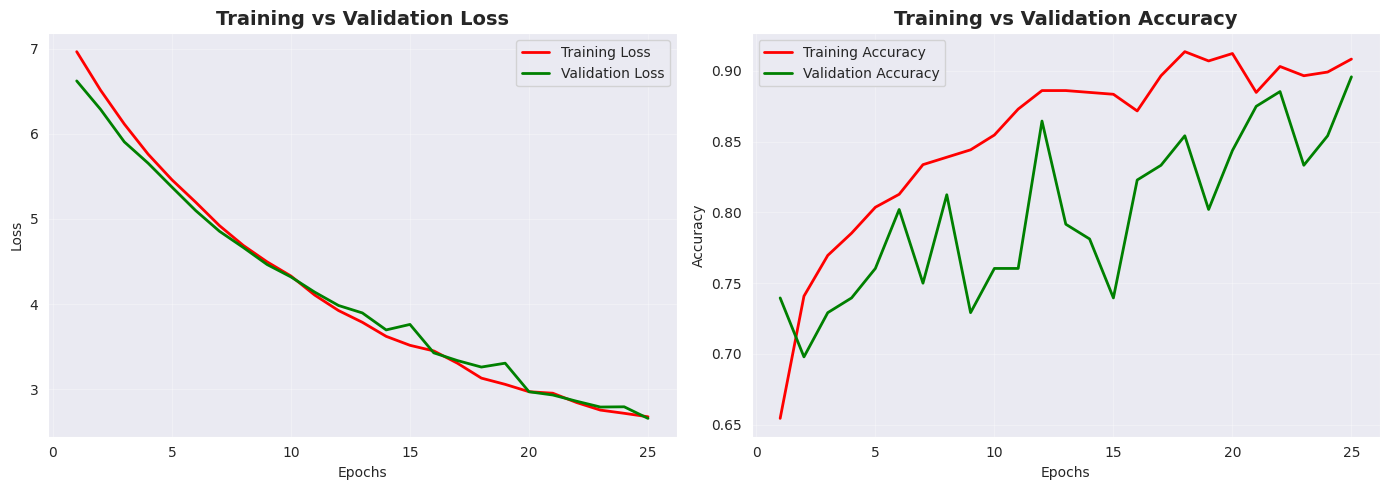

In [ ]:
# Phase 2: Fine-tuning top 40% of layers
print("\n" + "="*60)
print("PHASE 2: Fine-tuning Top 40% Layers (25 epochs)")
print("="*60)

total_layers = len(base_model.layers)
unfreeze_from = int(total_layers * 0.6)

for layer in base_model.layers[:unfreeze_from]:
    layer.trainable = False
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

print(f"Unfrozen {total_layers - unfreeze_from} layers")

# Recompile with lower learning rate
model.compile(
    optimizer=Nadam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

history2 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

plot_training(history2)

## Phase 3: Deep Fine-Tuning

Further unfreezes 60% of the InceptionV3 base layers for deeper fine-tuning.  
Trains with an even lower learning rate to refine higher-level feature representations and boost final model performance.



PHASE 3: Fine-tuning Top 60% Layers (20 epochs)
Unfrozen 187 layers
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8708 - auc: 0.9438 - loss: 2.6142 - precision: 0.8708 - recall: 0.8708


Validation F1-Score: 0.7995
64/64 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8713 - auc: 0.9441 - loss: 2.6129 - precision: 0.8713 - recall: 0.8713 - val_accuracy: 0.8021 - val_auc: 0.9262 - val_loss: 2.5685 - val_precision: 0.8021 - val_recall: 0.8021 - learning_rate: 5.0000e-05 - val_f1: 0.7995
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9037 - auc: 0.9551 - loss: 2.4694 - precision: 0.9037 - recall: 0.9037


Validation F1-Score: 0.8206
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 787ms/step - accuracy: 0.9035 - auc: 0.9550 - loss: 2.4694 - precision: 0.9035 - recall: 0.9035 - val_accuracy: 0.8229 - val_auc: 0.9240 - val_loss: 2.5101 - val_precision: 0.8229 - val_recall: 0.8229 - learning_rate: 5.0000e-05 - val_f1: 0.8206
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9102 - auc: 0.9643 - loss: 2.3748 - precision: 0.9102 - recall: 0.9102


Validation F1-Score: 0.8628
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 694ms/step - accuracy: 0.9103 - auc: 0.9643 - loss: 2.3744 - precision: 0.9103 - recall: 0.9103 - val_accuracy: 0.8646 - val_auc: 0.9335 - val_loss: 2.4029 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 5.0000e-05 - val_f1: 0.8628
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9399 - auc: 0.9765 - loss: 2.2592 - precision: 0.9399 - recall: 0.9399


Validation F1-Score: 0.8853
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 686ms/step - accuracy: 0.9395 - auc: 0.9764 - loss: 2.2596 - precision: 0.9395 - recall: 0.9395 - val_accuracy: 0.8854 - val_auc: 0.9556 - val_loss: 2.2984 - val_precision: 0.8854 - val_recall: 0.8854 - learning_rate: 5.0000e-05 - val_f1: 0.8853
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9042 - auc: 0.9659 - loss: 2.2567 - precision: 0.9042 - recall: 0.9042


Validation F1-Score: 0.8851
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 758ms/step - accuracy: 0.9041 - auc: 0.9658 - loss: 2.2568 - precision: 0.9041 - recall: 0.9041 - val_accuracy: 0.8854 - val_auc: 0.9622 - val_loss: 2.2408 - val_precision: 0.8854 - val_recall: 0.8854 - learning_rate: 5.0000e-05 - val_f1: 0.8851
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9105 - auc: 0.9728 - loss: 2.1862 - precision: 0.9105 - recall: 0.9105


Validation F1-Score: 0.9057
✓ New best F1-Score: 0.9057
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 759ms/step - accuracy: 0.9106 - auc: 0.9727 - loss: 2.1863 - precision: 0.9106 - recall: 0.9106 - val_accuracy: 0.9062 - val_auc: 0.9571 - val_loss: 2.2719 - val_precision: 0.9062 - val_recall: 0.9062 - learning_rate: 5.0000e-05 - val_f1: 0.9057
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9099 - auc: 0.9711 - loss: 2.1586 - precision: 0.9099 - recall: 0.9099


Validation F1-Score: 0.9271
✓ New best F1-Score: 0.9271
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 777ms/step - accuracy: 0.9097 - auc: 0.9710 - loss: 2.1586 - precision: 0.9097 - recall: 0.9097 - val_accuracy: 0.9271 - val_auc: 0.9658 - val_loss: 2.1712 - val_precision: 0.9271 - val_recall: 0.9271 - learning_rate: 5.0000e-05 - val_f1: 0.9271
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9172 - auc: 0.9729 - loss: 2.1093 - precision: 0.9172 - recall: 0.9172


Validation F1-Score: 0.9270
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 757ms/step - accuracy: 0.9173 - auc: 0.9730 - loss: 2.1089 - precision: 0.9173 - recall: 0.9173 - val_accuracy: 0.9271 - val_auc: 0.9683 - val_loss: 2.1105 - val_precision: 0.9271 - val_recall: 0.9271 - learning_rate: 5.0000e-05 - val_f1: 0.9270
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9026 - auc: 0.9673 - loss: 2.0801 - precision: 0.9026 - recall: 0.9026


Validation F1-Score: 0.8851
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 756ms/step - accuracy: 0.9027 - auc: 0.9674 - loss: 2.0798 - precision: 0.9027 - recall: 0.9027 - val_accuracy: 0.8854 - val_auc: 0.9510 - val_loss: 2.1267 - val_precision: 0.8854 - val_recall: 0.8854 - learning_rate: 5.0000e-05 - val_f1: 0.8851
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9257 - auc: 0.9699 - loss: 2.0367 - precision: 0.9257 - recall: 0.9257


Validation F1-Score: 0.9060
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 769ms/step - accuracy: 0.9256 - auc: 0.9699 - loss: 2.0366 - precision: 0.9256 - recall: 0.9256 - val_accuracy: 0.9062 - val_auc: 0.9594 - val_loss: 2.0639 - val_precision: 0.9062 - val_recall: 0.9062 - learning_rate: 5.0000e-05 - val_f1: 0.9060
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9233 - auc: 0.9767 - loss: 1.9839 - precision: 0.9233 - recall: 0.9233


Validation F1-Score: 0.8853
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 686ms/step - accuracy: 0.9234 - auc: 0.9767 - loss: 1.9838 - precision: 0.9234 - recall: 0.9234 - val_accuracy: 0.8854 - val_auc: 0.9561 - val_loss: 2.0416 - val_precision: 0.8854 - val_recall: 0.8854 - learning_rate: 5.0000e-05 - val_f1: 0.8853
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9364 - auc: 0.9835 - loss: 1.9237 - precision: 0.9364 - recall: 0.9364


Validation F1-Score: 0.8642
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 764ms/step - accuracy: 0.9364 - auc: 0.9834 - loss: 1.9239 - precision: 0.9364 - recall: 0.9364 - val_accuracy: 0.8646 - val_auc: 0.9494 - val_loss: 2.0242 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 5.0000e-05 - val_f1: 0.8642
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9331 - auc: 0.9740 - loss: 1.9343 - precision: 0.9331 - recall: 0.9331


Validation F1-Score: 0.8645
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 776ms/step - accuracy: 0.9329 - auc: 0.9739 - loss: 1.9343 - precision: 0.9329 - recall: 0.9329 - val_accuracy: 0.8646 - val_auc: 0.9659 - val_loss: 1.9513 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 5.0000e-05 - val_f1: 0.8645
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9368 - auc: 0.9794 - loss: 1.9008 - precision: 0.9368 - recall: 0.9368


Validation F1-Score: 0.8645
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 726ms/step - accuracy: 0.9364 - auc: 0.9793 - loss: 1.9013 - precision: 0.9364 - recall: 0.9364 - val_accuracy: 0.8646 - val_auc: 0.9634 - val_loss: 1.9459 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 5.0000e-05 - val_f1: 0.8645
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9407 - auc: 0.9819 - loss: 1.8795 - precision: 0.9407 - recall: 0.9407


Validation F1-Score: 0.9374
✓ New best F1-Score: 0.9374
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 744ms/step - accuracy: 0.9405 - auc: 0.9819 - loss: 1.8795 - precision: 0.9405 - recall: 0.9405 - val_accuracy: 0.9375 - val_auc: 0.9747 - val_loss: 1.8983 - val_precision: 0.9375 - val_recall: 0.9375 - learning_rate: 5.0000e-05 - val_f1: 0.9374
Epoch 16/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.8859 - auc: 0.9505 - loss: 1.9742 - precision: 0.8859 - recall: 0.8859


Validation F1-Score: 0.8748
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 754ms/step - accuracy: 0.8862 - auc: 0.9507 - loss: 1.9734 - precision: 0.8862 - recall: 0.8862 - val_accuracy: 0.8750 - val_auc: 0.9719 - val_loss: 1.8893 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 5.0000e-05 - val_f1: 0.8748
Epoch 17/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9533 - auc: 0.9857 - loss: 1.8142 - precision: 0.9533 - recall: 0.9533


Validation F1-Score: 0.9167
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 784ms/step - accuracy: 0.9532 - auc: 0.9856 - loss: 1.8143 - precision: 0.9532 - recall: 0.9532 - val_accuracy: 0.9167 - val_auc: 0.9753 - val_loss: 1.8481 - val_precision: 0.9167 - val_recall: 0.9167 - learning_rate: 5.0000e-05 - val_f1: 0.9167
Epoch 18/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9294 - auc: 0.9710 - loss: 1.8435 - precision: 0.9294 - recall: 0.9294


Validation F1-Score: 0.9270
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 763ms/step - accuracy: 0.9294 - auc: 0.9710 - loss: 1.8434 - precision: 0.9294 - recall: 0.9294 - val_accuracy: 0.9271 - val_auc: 0.9640 - val_loss: 1.8955 - val_precision: 0.9271 - val_recall: 0.9271 - learning_rate: 5.0000e-05 - val_f1: 0.9270
Epoch 19/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9333 - auc: 0.9831 - loss: 1.8027 - precision: 0.9333 - recall: 0.9333


Validation F1-Score: 0.9375
✓ New best F1-Score: 0.9375
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 695ms/step - accuracy: 0.9334 - auc: 0.9831 - loss: 1.8025 - precision: 0.9334 - recall: 0.9334 - val_accuracy: 0.9375 - val_auc: 0.9649 - val_loss: 1.8752 - val_precision: 0.9375 - val_recall: 0.9375 - learning_rate: 5.0000e-05 - val_f1: 0.9375
Epoch 20/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9482 - auc: 0.9875 - loss: 1.7497 - precision: 0.9482 - recall: 0.9482


Validation F1-Score: 0.8951
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 811ms/step - accuracy: 0.9479 - auc: 0.9875 - loss: 1.7499 - precision: 0.9479 - recall: 0.9479 - val_accuracy: 0.8958 - val_auc: 0.9558 - val_loss: 1.8745 - val_precision: 0.8958 - val_recall: 0.8958 - learning_rate: 5.0000e-05 - val_f1: 0.8951


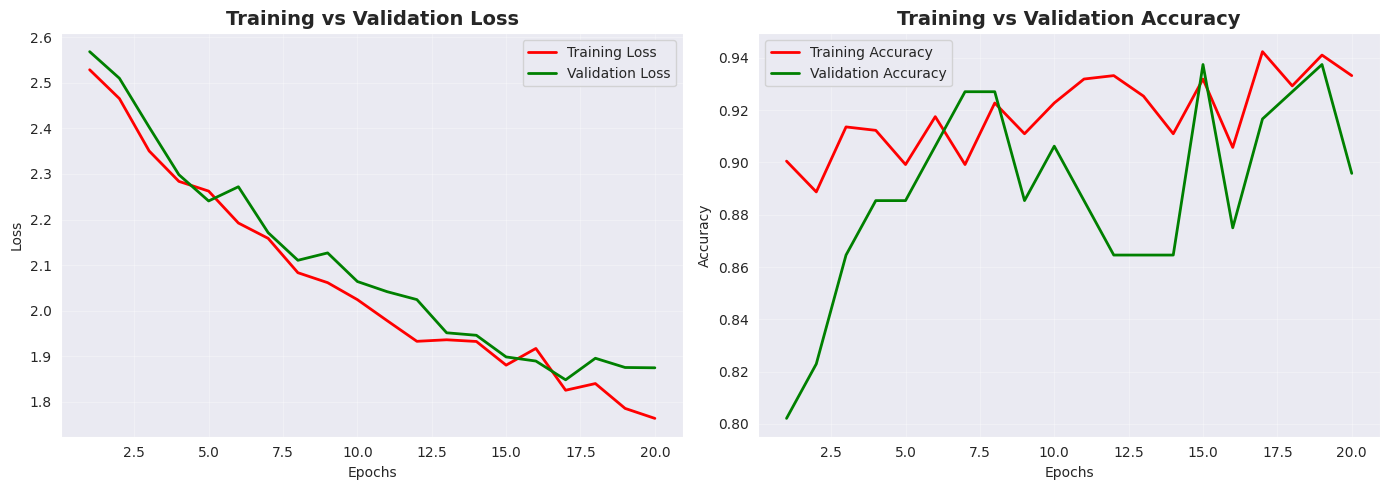

In [ ]:
# Phase 3: Fine-tuning top 60% of layers
print("\n" + "="*60)
print("PHASE 3: Fine-tuning Top 60% Layers (20 epochs)")
print("="*60)

unfreeze_from = int(total_layers * 0.4)

for layer in base_model.layers[:unfreeze_from]:
    layer.trainable = False
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

print(f"Unfrozen {total_layers - unfreeze_from} layers")

model.compile(
    optimizer=Nadam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

history3 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

plot_training(history3)

## Phase 4: Full Model Fine-Tuning

Unfreezes all layers of the InceptionV3 base and trains the complete model with a very low learning rate.  
This final phase fine-tunes the entire network for maximum accuracy and stability.



PHASE 4: Full Model Fine-tuning (15 epochs)
All 311 layers unfrozen
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8801 - auc: 0.9397 - loss: 1.9062 - precision: 0.8801 - recall: 0.8801


Validation F1-Score: 0.8951
64/64 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8802 - auc: 0.9398 - loss: 1.9060 - precision: 0.8802 - recall: 0.8802 - val_accuracy: 0.8958 - val_auc: 0.9662 - val_loss: 1.7916 - val_precision: 0.8958 - val_recall: 0.8958 - learning_rate: 1.0000e-05 - val_f1: 0.8951
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9229 - auc: 0.9785 - loss: 1.7535 - precision: 0.9229 - recall: 0.9229


Validation F1-Score: 0.9165
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 765ms/step - accuracy: 0.9230 - auc: 0.9785 - loss: 1.7533 - precision: 0.9230 - recall: 0.9230 - val_accuracy: 0.9167 - val_auc: 0.9793 - val_loss: 1.7555 - val_precision: 0.9167 - val_recall: 0.9167 - learning_rate: 1.0000e-05 - val_f1: 0.9165
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.8855 - auc: 0.9482 - loss: 1.8366 - precision: 0.8855 - recall: 0.8855


Validation F1-Score: 0.8749
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 876ms/step - accuracy: 0.8859 - auc: 0.9485 - loss: 1.8356 - precision: 0.8859 - recall: 0.8859 - val_accuracy: 0.8750 - val_auc: 0.9683 - val_loss: 1.7636 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-05 - val_f1: 0.8749
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9290 - auc: 0.9788 - loss: 1.7173 - precision: 0.9290 - recall: 0.9290


Validation F1-Score: 0.8957
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 833ms/step - accuracy: 0.9290 - auc: 0.9788 - loss: 1.7172 - precision: 0.9290 - recall: 0.9290 - val_accuracy: 0.8958 - val_auc: 0.9633 - val_loss: 1.7642 - val_precision: 0.8958 - val_recall: 0.8958 - learning_rate: 1.0000e-05 - val_f1: 0.8957
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9179 - auc: 0.9774 - loss: 1.7090 - precision: 0.9179 - recall: 0.9179


Validation F1-Score: 0.8745
64/64 ━━━━━━━━━━━━━━━━━━━━ 45s 703ms/step - accuracy: 0.9178 - auc: 0.9774 - loss: 1.7091 - precision: 0.9178 - recall: 0.9178 - val_accuracy: 0.8750 - val_auc: 0.9521 - val_loss: 1.7772 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-05 - val_f1: 0.8745
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9228 - auc: 0.9798 - loss: 1.6870 - precision: 0.9228 - recall: 0.9228


Validation F1-Score: 0.8539
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 836ms/step - accuracy: 0.9228 - auc: 0.9798 - loss: 1.6870 - precision: 0.9228 - recall: 0.9228 - val_accuracy: 0.8542 - val_auc: 0.9441 - val_loss: 1.7753 - val_precision: 0.8542 - val_recall: 0.8542 - learning_rate: 1.0000e-05 - val_f1: 0.8539
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9439 - auc: 0.9813 - loss: 1.6656 - precision: 0.9439 - recall: 0.9439


Validation F1-Score: 0.8433
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 869ms/step - accuracy: 0.9439 - auc: 0.9812 - loss: 1.6657 - precision: 0.9439 - recall: 0.9439 - val_accuracy: 0.8438 - val_auc: 0.9392 - val_loss: 1.7758 - val_precision: 0.8438 - val_recall: 0.8438 - learning_rate: 1.0000e-05 - val_f1: 0.8433
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9406 - auc: 0.9884 - loss: 1.6274 - precision: 0.9406 - recall: 0.9406
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.



Validation F1-Score: 0.8429
64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 981ms/step - accuracy: 0.9405 - auc: 0.9884 - loss: 1.6276 - precision: 0.9405 - recall: 0.9405 - val_accuracy: 0.8438 - val_auc: 0.9367 - val_loss: 1.7906 - val_precision: 0.8438 - val_recall: 0.8438 - learning_rate: 1.0000e-05 - val_f1: 0.8429
Epoch 9/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.9242 - auc: 0.9809 - loss: 1.6536 - precision: 0.9242 - recall: 0.9242


Validation F1-Score: 0.8536
64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9243 - auc: 0.9809 - loss: 1.6535 - precision: 0.9243 - recall: 0.9243 - val_accuracy: 0.8542 - val_auc: 0.9329 - val_loss: 1.7990 - val_precision: 0.8542 - val_recall: 0.8542 - learning_rate: 2.0000e-06 - val_f1: 0.8536
Epoch 10/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9176 - auc: 0.9707 - loss: 1.6878 - precision: 0.9176 - recall: 0.9176


Validation F1-Score: 0.8642
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 907ms/step - accuracy: 0.9178 - auc: 0.9708 - loss: 1.6873 - precision: 0.9178 - recall: 0.9178 - val_accuracy: 0.8646 - val_auc: 0.9380 - val_loss: 1.7947 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 2.0000e-06 - val_f1: 0.8642
Epoch 11/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.9247 - auc: 0.9730 - loss: 1.6718 - precision: 0.9247 - recall: 0.9247


Validation F1-Score: 0.8745
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 871ms/step - accuracy: 0.9248 - auc: 0.9731 - loss: 1.6716 - precision: 0.9248 - recall: 0.9248 - val_accuracy: 0.8750 - val_auc: 0.9391 - val_loss: 1.7811 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 2.0000e-06 - val_f1: 0.8745
Epoch 12/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9256 - auc: 0.9752 - loss: 1.6631 - precision: 0.9256 - recall: 0.9256


Validation F1-Score: 0.8642
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 983ms/step - accuracy: 0.9256 - auc: 0.9752 - loss: 1.6630 - precision: 0.9256 - recall: 0.9256 - val_accuracy: 0.8646 - val_auc: 0.9376 - val_loss: 1.7860 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 2.0000e-06 - val_f1: 0.8642
Epoch 13/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9464 - auc: 0.9832 - loss: 1.6173 - precision: 0.9464 - recall: 0.9464


Validation F1-Score: 0.8642
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 874ms/step - accuracy: 0.9462 - auc: 0.9831 - loss: 1.6177 - precision: 0.9462 - recall: 0.9462 - val_accuracy: 0.8646 - val_auc: 0.9417 - val_loss: 1.7871 - val_precision: 0.8646 - val_recall: 0.8646 - learning_rate: 2.0000e-06 - val_f1: 0.8642
Epoch 14/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9540 - auc: 0.9889 - loss: 1.6027 - precision: 0.9540 - recall: 0.9540


Validation F1-Score: 0.8333
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 869ms/step - accuracy: 0.9538 - auc: 0.9888 - loss: 1.6030 - precision: 0.9538 - recall: 0.9538 - val_accuracy: 0.8333 - val_auc: 0.9419 - val_loss: 1.7698 - val_precision: 0.8333 - val_recall: 0.8333 - learning_rate: 2.0000e-06 - val_f1: 0.8333
Epoch 15/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9351 - auc: 0.9788 - loss: 1.6390 - precision: 0.9351 - recall: 0.9351
Epoch 15: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.



Validation F1-Score: 0.8745
64/64 ━━━━━━━━━━━━━━━━━━━━ 60s 939ms/step - accuracy: 0.9351 - auc: 0.9788 - loss: 1.6388 - precision: 0.9351 - recall: 0.9351 - val_accuracy: 0.8750 - val_auc: 0.9418 - val_loss: 1.7839 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 2.0000e-06 - val_f1: 0.8745


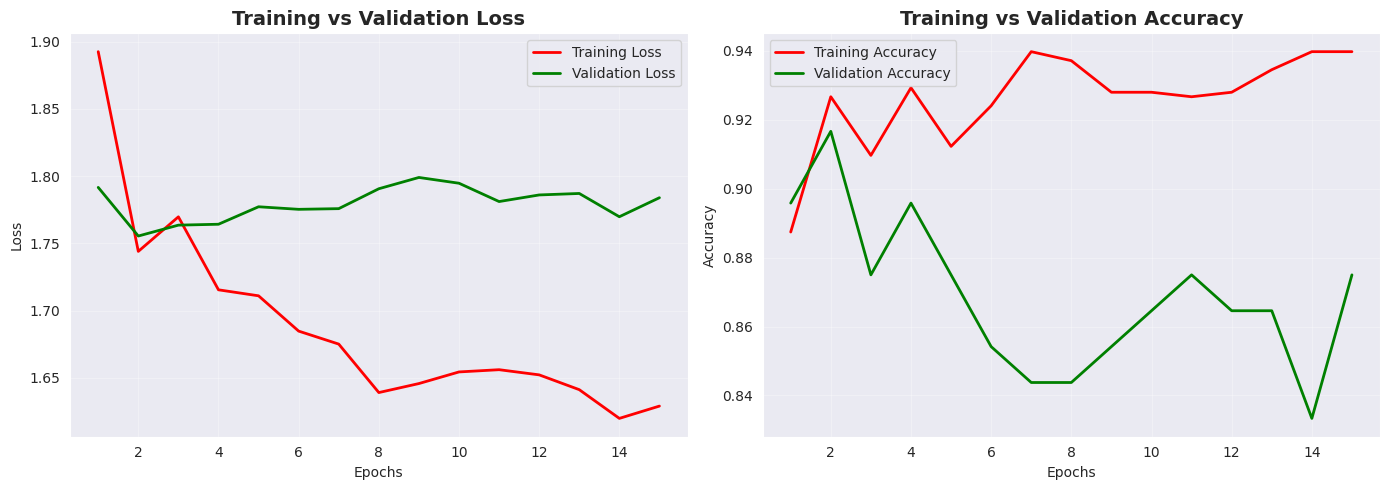

In [ ]:
# Phase 4: Full fine-tuning with very low LR
print("\n" + "="*60)
print("PHASE 4: Full Model Fine-tuning (15 epochs)")
print("="*60)

# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

print(f"All {total_layers} layers unfrozen")

model.compile(
    optimizer=Nadam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

history4 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

plot_training(history4)

## Model Evaluation and Test-Time Augmentation

Loads the best saved model and evaluates it on the test set.  
Reports standard performance metrics including accuracy, AUC, precision, and recall.  
Additionally applies Test-Time Augmentation (TTA) for more stable predictions and computes TTA-based accuracy and F1-score.  
Displays the confusion matrix and a detailed classification report for final assessment.



Loading Best Model for Evaluation



STANDARD EVALUATION
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 375ms/step - accuracy: 0.8973 - auc: 0.9755 - loss: 1.6457 - precision: 0.8973 - recall: 0.8973

Standard Test Results:
Test Loss:      1.6703
Test Accuracy:  0.8854
Test AUC:       0.9696
Test Precision: 0.8854
Test Recall:    0.8854

TEST-TIME AUGMENTATION EVALUATION
Generating TTA predictions...
  Processed 5/8 batches

TTA Test Results:
TTA Accuracy:  0.8854 (88.54%)
TTA F1-Score:  0.8851
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step

Confusion Matrix (Standard Prediction)


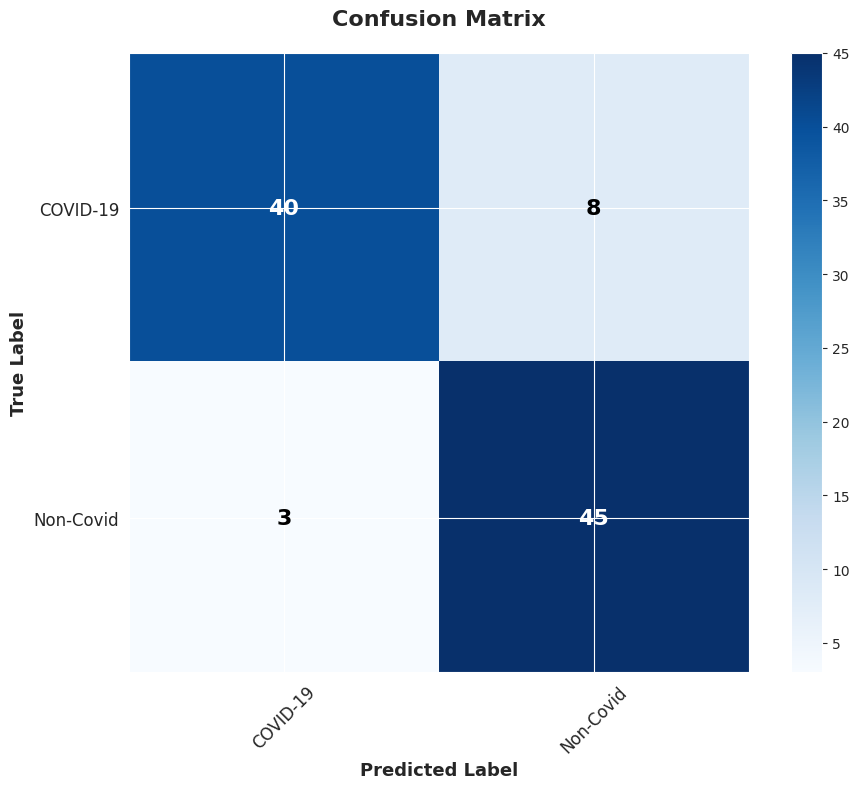


Classification Report:
              precision    recall  f1-score   support

    COVID-19     0.9302    0.8333    0.8791        48
   Non-Covid     0.8491    0.9375    0.8911        48

    accuracy                         0.8854        96
   macro avg     0.8896    0.8854    0.8851        96
weighted avg     0.8896    0.8854    0.8851        96



In [ ]:
# Load best model
print("\n" + "="*60)
print("Loading Best Model for Evaluation")
print("="*60)
model = keras.models.load_model('best_inceptionv3_enhanced.h5')

# Standard evaluation
print("\n" + "="*60)
print("STANDARD EVALUATION")
print("="*60)

test_results = model.evaluate(test_gen, verbose=1)
print(f"\n{'='*60}")
print(f"Standard Test Results:")
print(f"{'='*60}")
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]:.4f}")
print(f"Test AUC:       {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall:    {test_results[4]:.4f}")

# Test-Time Augmentation evaluation
print("\n" + "="*60)
print("TEST-TIME AUGMENTATION EVALUATION")
print("="*60)

tta_predictor = TTAPredictor(model, n_augments=7)

print("Generating TTA predictions...")
tta_preds = []
for i in range(len(test_gen)):
    batch_x, _ = test_gen[i]
    tta_pred = tta_predictor.predict(batch_x)
    tta_preds.append(tta_pred)
    if (i + 1) % 5 == 0:
        print(f"  Processed {i + 1}/{len(test_gen)} batches")

tta_preds = np.vstack(tta_preds)[:len(test_gen.classes)]
y_pred_tta = np.argmax(tta_preds, axis=1)

# Calculate TTA metrics
tta_acc = np.mean(y_pred_tta == test_gen.classes)
tta_f1 = f1_score(test_gen.classes, y_pred_tta, average='weighted')

print(f"\n{'='*60}")
print(f"TTA Test Results:")
print(f"{'='*60}")
print(f"TTA Accuracy:  {tta_acc:.4f} ({tta_acc*100:.2f}%)")
print(f"TTA F1-Score:  {tta_f1:.4f}")

# Confusion Matrix
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)

print("\n" + "="*60)
print("Confusion Matrix (Standard Prediction)")
print("="*60)
plot_confusion_matrix(cm, list(test_gen.class_indices.keys()))

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(
    test_gen.classes, y_pred,
    target_names=list(test_gen.class_indices.keys()),
    digits=4
))

## Saving the Model and Training Metadata

Saves the final trained model, class label mappings, and complete training history for future use.  
Ensures reproducibility and easy deployment by exporting model weights and performance logs.


In [ ]:
# Save model and metadata
os.makedirs("saved_model_enhanced_v3", exist_ok=True)
model.save("saved_model_enhanced_v3/covid_inceptionv3_best.h5")
print("\n✓ Model saved at saved_model_enhanced_v3/covid_inceptionv3_best.h5")

class_df = pd.DataFrame(
    list(train_gen.class_indices.items()),
    columns=['Label', 'Index']
)
class_df.to_csv("saved_model_enhanced_v3/class_indices.csv", index=False)

all_history = {
    'epoch': list(range(1, len(history1.history['loss']) + len(history2.history['loss']) +
                       len(history3.history['loss']) + len(history4.history['loss']) + 1)),
    'train_acc': (history1.history['accuracy'] + history2.history['accuracy'] +
                 history3.history['accuracy'] + history4.history['accuracy']),
    'val_acc': (history1.history['val_accuracy'] + history2.history['val_accuracy'] +
               history3.history['val_accuracy'] + history4.history['val_accuracy']),
    'train_loss': (history1.history['loss'] + history2.history['loss'] +
                  history3.history['loss'] + history4.history['loss']),
    'val_loss': (history1.history['val_loss'] + history2.history['val_loss'] +
                history3.history['val_loss'] + history4.history['val_loss'])
}
history_df = pd.DataFrame(all_history)
history_df.to_csv("saved_model_enhanced_v3/training_history.csv", index=False)
print("✓ Training history saved")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


✓ Model saved at saved_model_enhanced_v3/covid_inceptionv3_best.h5
✓ Training history saved

🎉 TRAINING COMPLETE!
